In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import os

In [2]:
# List of all the lineages we will be making dataframes for - some of the DFs don't have a col named depmapid but have depmapids, will require some cleaning
lineages = ["kidney", "breast", "blood", "liver", "urinary_tract", "colorectal", "ovary", "pancreas"]
lineage_df_dict = {}

In [3]:
# List of all the feature dataframes we are going to read into the lineage dataframes
features = ["effect", "dependency", "expression", "gene_cn"]
feature_df_dict = {}

In [4]:
sample_info_df = pd.read_csv('data/sample_info.csv')

In [5]:
folder_path = "data/"

for file_name in os.listdir(folder_path):
    for feature in features:
        if file_name.endswith('.csv') and feature in file_name:
            file_path = os.path.join(folder_path, file_name)
            feature_df_dict[feature] = pd.read_csv(file_path)
            feature_df_dict[feature].columns = [column.split(' ')[0] for column in feature_df_dict[feature].columns]
            feature_df_dict[feature].rename(columns={feature_df_dict[feature].columns[0]: "DepMap_ID"}, inplace=True)
            feature_df_dict[feature] = pd.merge(feature_df_dict[feature], sample_info_df[['DepMap_ID', 'lineage']], on='DepMap_ID', how='left')
            feature_df_dict[feature].drop("DepMap_ID", axis=1, inplace=True)
            feature_df_dict[feature] = feature_df_dict[feature].pivot_table(index='lineage', aggfunc='mean')

In [6]:
for feature in features:
    for lineage in lineages:
        temp_df = feature_df_dict[feature].loc[feature_df_dict[feature].index == lineage].transpose()
        temp_df.index.name = 'gene'
        if lineage in lineage_df_dict:
            temp_df.rename(columns={lineage : feature}, inplace=True)
            lineage_df_dict[lineage] = pd.merge(lineage_df_dict[lineage], temp_df, on="gene", how="outer").dropna()
        else:
            lineage_df_dict[lineage] = pd.DataFrame({feature: temp_df[lineage]}, index=temp_df.index)
            lineage_df_dict[lineage].index.name = 'gene'
            lineage_df_dict[lineage].reset_index(inplace=True)

In [7]:
training_dfs = {}
training_lineages = {"kidney" : "kidney", 
                     "breast" : "breast", 
                     "leukemia" : "blood", 
                     "liver" : "liver", 
                     "bladder" : "urinary_tract",
                     "colon" : "colorectal", 
                     "ovarian" : "ovary", 
                     "pancreatic" : "pancreas"}

for k, v in training_lineages.items():
    # get the df from the training set
    df = pd.read_csv(f"training_sets_genes/{k}_training_genes_set.csv")
    df = df.merge(lineage_df_dict[v], on="gene", how='left').fillna(0)
    
    # drop all training genes from the prediction set
    lineage_df_dict[v] = pd.merge(lineage_df_dict[v], df, indicator=True, how='left', on=list(lineage_df_dict[v].columns)).query('_merge == "left_only"').drop('_merge', axis=1)
    lineage_df_dict[v].drop(columns=['label'], inplace=True)
    df.set_index('gene', inplace=True)
    lineage_df_dict[v].set_index('gene', inplace=True)
    
    # split into 10 samples for 50-50 pos neg split
    samples = []
    for negatives in np.array_split(df[df['label'] == 'negative'], 10):
        samples.append(pd.concat([df[df['label'] == "positive"], negatives]))
    
    training_dfs[k] = samples

In [8]:
rev_training_lineages = {value: key for key, value in training_lineages.items()}

## Random Forest

In [9]:
rf_by_lineage = {}

param_grid = {
    'max_depth' : [4, 5, 6],
    'n_estimators': [250, 375, 500],
    'max_features': ['sqrt', 'log2', 0.3]}

rf = RandomForestClassifier()

skf = StratifiedKFold(n_splits=5,shuffle=True)

# Run on train data
for k, v in training_dfs.items():
    accuracy = 0
    for df in v:
        X = df.drop(columns=['label'])
        y = df['label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        grid_search_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf)

        model = grid_search_cv.fit(X_train, y_train)

        y_pred = model.best_estimator_.predict(X_test)
        y_pred_rt = model.best_estimator_.predict_proba(X_test)[:, 1]

        accuracy += accuracy_score(y_test, y_pred)

    rf_by_lineage[k] = (accuracy/len(v), y_pred, y_pred_rt, X_test, y_test, model.best_estimator_)

In [13]:
# Predict on Unlabelled Data
rf_predictions = {}
rf_pred_labels = {}

for k, v in lineage_df_dict.items():
    rev_k = rev_training_lineages[k]
    best_rf = rf_by_lineage[rev_k][-1]
    rf_pred_labels[rev_k] = best_rf.predict(lineage_df_dict[k])
    rf_predictions[k] = pd.DataFrame({'gene': v.index, 'prediction': rf_pred_labels[rev_k]})

In [15]:
for key in rev_training_lineages:
    pos_count = 0
    for prediction in rf_predictions[key]["prediction"]:
        if prediction == "positive":
            pos_count += 1

    print(f"{key} : {pos_count}")

kidney : 14077
breast : 4869
blood : 6160
liver : 6167
urinary_tract : 5232
colorectal : 6859
ovary : 5725
pancreas : 9538


In [16]:
for k, v in training_dfs.items():
    accuracy = rf_by_lineage[k][0]
    print(f"{k} accuracy: {accuracy}")

kidney accuracy: 0.6272727272727273
breast accuracy: 0.5199999999999999
leukemia accuracy: 0.5815217391304348
liver accuracy: 0.5210526315789473
bladder accuracy: 0.5058823529411766
colon accuracy: 0.3823529411764707
ovarian accuracy: 0.5521739130434782
pancreatic accuracy: 0.4954545454545455


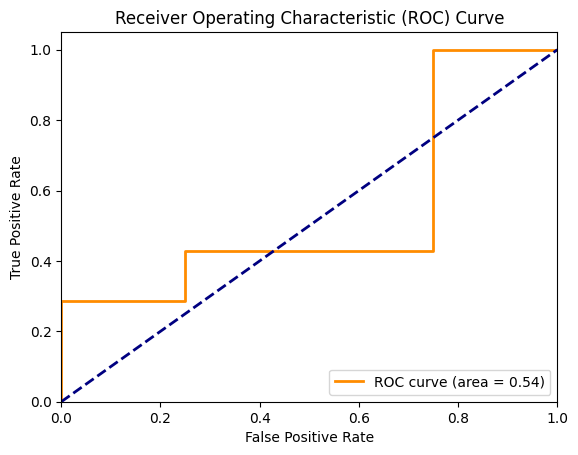

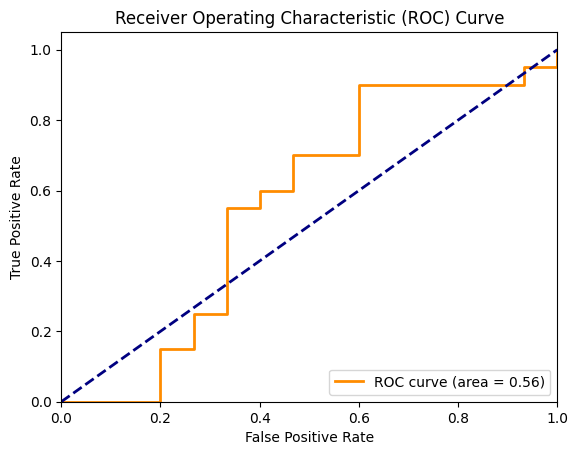

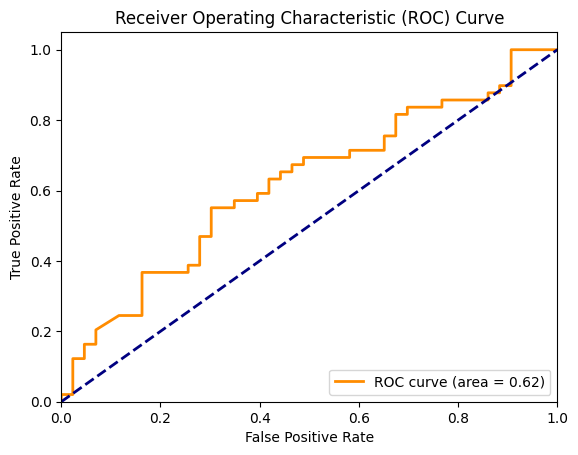

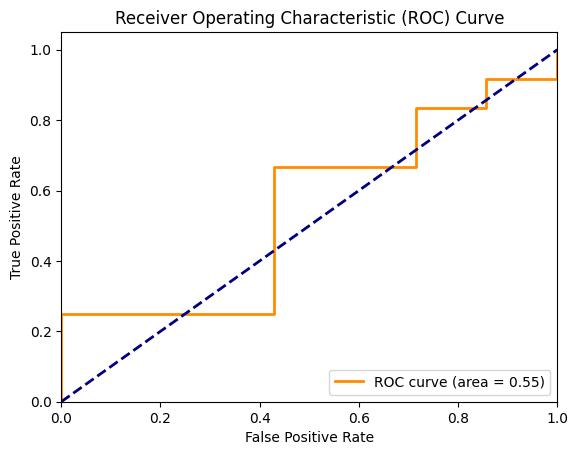

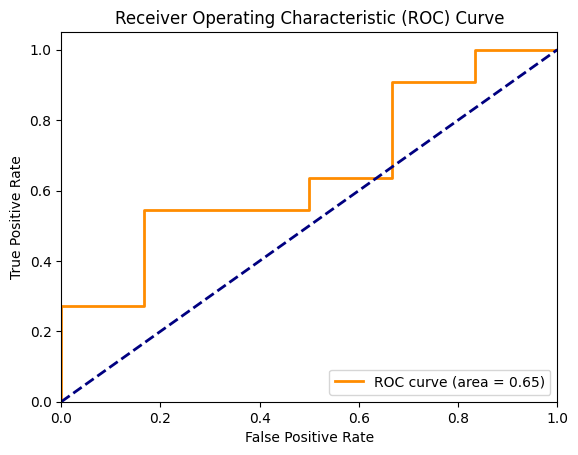

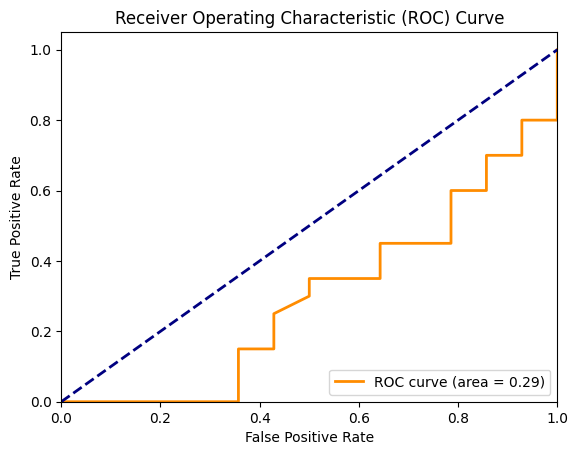

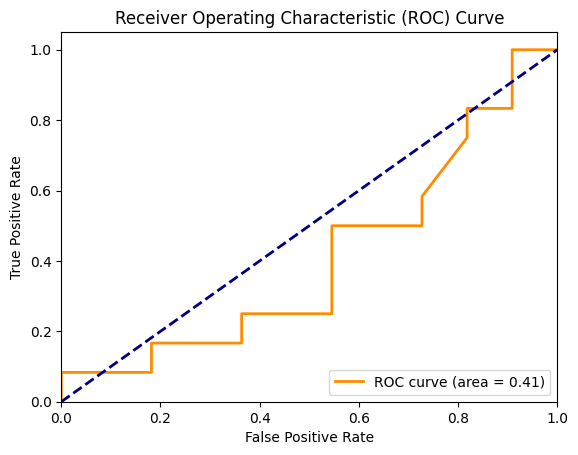

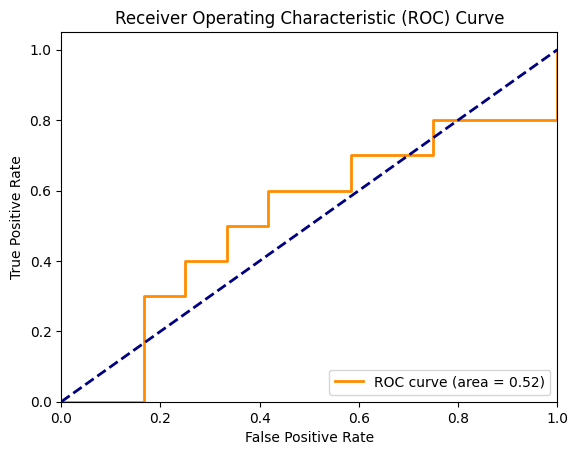

In [17]:
for k, v in training_dfs.items():
    X_test = rf_by_lineage[k][-3]
    y_test = rf_by_lineage[k][-2]
    best_model = rf_by_lineage[k][-1]

    lb = LabelBinarizer()
    y_test_binary = lb.fit_transform(y_test)   

    # Get predicted probabilities for the positive class (assuming binary classification)
    y_scores = best_model.predict_proba(X_test)[:, 1]
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
